In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import re
from networkx.drawing.nx_agraph import graphviz_layout
from itertools import product
from calendar_planner import Calendar

In [2]:
course_paths = {
    "databases.xlsx": "Databases INF/IK",
    "inleiding_ki.xlsx": "Inleiding kunstmatige intelligentie",
    "nwo.xlsx": "Netwerkorganisaties",
    "psas.xlsx": "Problem solving and search"
}
cal = Calendar()
cal.add_courses_from_excel(course_paths)
print(cal)

Calendar contains: Databases INF/IK, Inleiding kunstmatige intelligentie, Netwerkorganisaties, Problem solving and search


In [3]:
def create_graph_from_calendar(calendar: Calendar, hierarchy: list) -> nx.Graph:
    """ Creates an adjaceny matrix 
    
    Parameters:
        calendar: Calendar object, must contain courses
        hierarchy: order of 'layers', order does not matter
    """
    # create adjacency matrix
    n = sum(len(course) for course in calendar.courses.values())
    cols = sum([
        [course_title + "---" + practical.group for practical in course.practical_lectures.values()] 
            for course_title, course in calendar.courses.items()
    ], [])
    adj_matrix = pd.DataFrame(np.zeros((n, n)), columns=cols, index=cols, dtype=int)

    # add edges between 'layers' in adj matrix
    for i in range(len(hierarchy) - 1):
        first_layer = hierarchy[i]
        second_layer = hierarchy[i + 1]
        adj_matrix.loc[adj_matrix.index.str.startswith(first_layer), 
                       adj_matrix.columns.str.startswith(second_layer)] = 1
        
    return nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph())

In [4]:
def draw_as_nn(G: nx.Graph, labels=False) -> None:
    """ Draws graph in neural network format """
    pos = graphviz_layout(G, prog='dot', args="-Grankdir=LR")
    nx.draw(G,with_labels=labels,pos=pos)

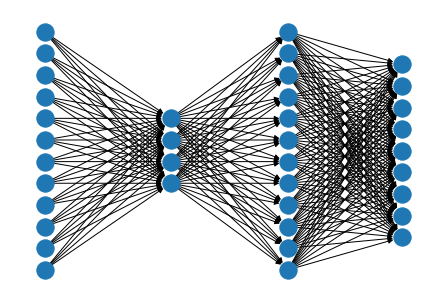

In [5]:
hierarchy = list(cal.courses.keys())
import random
random.shuffle(hierarchy)

G = create_graph_from_calendar(cal, hierarchy)
draw_as_nn(G)

In [6]:
remove_edges = []

for node in G:
    course, group = node.split("---")
    neighbors = pd.DataFrame(
        pd.Series(G.neighbors(node))\
            .map(lambda x: x.split("---"))\
            .to_list()
    ).rename(columns={0: "course", 1: "group"})
    
    for index, row in neighbors.iterrows():
        overlap = cal.courses[course]\
                    .practical_lectures[group]\
                    .overlaps_with_course(cal, row["course"], row["group"])
        if overlap: 
            remove_edges.append((node, row["course"] + "---" + row["group"]))
            
G.remove_edges_from(remove_edges)
G.remove_nodes_from(list(nx.isolates(G)))

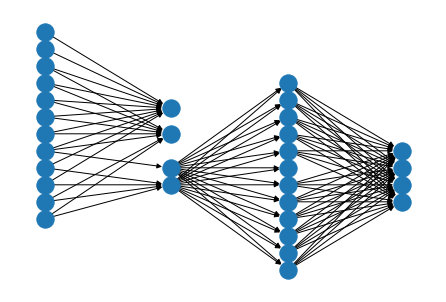

In [7]:
draw_as_nn(G)

In [8]:
source_target = (hierarchy[0], hierarchy[-1])
sources = []
targets = []

for node in G.nodes:
    if re.search(f"^{source_target[0]}", node):
        sources.append(node)
    elif re.search(f"^{source_target[1]}", node):
        targets.append(node)
    
has_paths = []
for u, v in product(sources, targets):
    has_paths.append((u, v, nx.has_path(G, u, v)))

In [9]:

for s_paths in nx.all_pairs_shortest_path(G):
    if s_paths[0].split("---")[0] != source_target[0]:
        continue
    print(s_paths)

('Inleiding kunstmatige intelligentie---A', {'Inleiding kunstmatige intelligentie---A': ['Inleiding kunstmatige intelligentie---A'], 'Netwerkorganisaties---A': ['Inleiding kunstmatige intelligentie---A', 'Netwerkorganisaties---A'], 'Netwerkorganisaties---C': ['Inleiding kunstmatige intelligentie---A', 'Netwerkorganisaties---C'], 'Problem solving and search---A': ['Inleiding kunstmatige intelligentie---A', 'Netwerkorganisaties---C', 'Problem solving and search---A'], 'Problem solving and search---B': ['Inleiding kunstmatige intelligentie---A', 'Netwerkorganisaties---C', 'Problem solving and search---B'], 'Problem solving and search---C': ['Inleiding kunstmatige intelligentie---A', 'Netwerkorganisaties---C', 'Problem solving and search---C'], 'Problem solving and search---D1': ['Inleiding kunstmatige intelligentie---A', 'Netwerkorganisaties---C', 'Problem solving and search---D1'], 'Problem solving and search---E1': ['Inleiding kunstmatige intelligentie---A', 'Netwerkorganisaties---C', '

In [10]:
source_target

('Inleiding kunstmatige intelligentie', 'Databases INF/IK')

In [11]:
has_paths

[('Inleiding kunstmatige intelligentie---A', 'Databases INF/IK---A', True),
 ('Inleiding kunstmatige intelligentie---A', 'Databases INF/IK---B', True),
 ('Inleiding kunstmatige intelligentie---A', 'Databases INF/IK---C', True),
 ('Inleiding kunstmatige intelligentie---A', 'Databases INF/IK---D', True),
 ('Inleiding kunstmatige intelligentie---B', 'Databases INF/IK---A', False),
 ('Inleiding kunstmatige intelligentie---B', 'Databases INF/IK---B', False),
 ('Inleiding kunstmatige intelligentie---B', 'Databases INF/IK---C', False),
 ('Inleiding kunstmatige intelligentie---B', 'Databases INF/IK---D', False),
 ('Inleiding kunstmatige intelligentie---C', 'Databases INF/IK---A', False),
 ('Inleiding kunstmatige intelligentie---C', 'Databases INF/IK---B', False),
 ('Inleiding kunstmatige intelligentie---C', 'Databases INF/IK---C', False),
 ('Inleiding kunstmatige intelligentie---C', 'Databases INF/IK---D', False),
 ('Inleiding kunstmatige intelligentie---D', 'Databases INF/IK---A', False),
 ('

In [12]:
hierarchy

['Inleiding kunstmatige intelligentie',
 'Netwerkorganisaties',
 'Problem solving and search',
 'Databases INF/IK']